In [2]:
from google.colab import drive
import pandas as pd
import pickle

drive.mount('/content/drive')


file_path_ori = '/content/drive/My Drive/GDG_ML_WING_DATASET/preprocesss_dataset.csv'
# file_path_top = '/content/drive/My Drive/GDSC_DATASET/topline_result.dat'
# file_path_base = '/content/drive/My Drive/GDSC_DATASET/baseline_result.dat'
TOP_info = 0
base_info = 0
try:
    with open(file_path_ori, 'r') as f:
        DATA = pd.read_csv(file_path_ori)
    # with open(file_path_top, 'rb') as f:
    #     TOP_info = pickle.load(f)
    # with open(file_path_base, 'rb') as f:
    #     base_info = pickle.load(f)
except FileNotFoundError:
    print("File NOT FOUND. Check the path and filename.")

Mounted at /content/drive


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
# Assume 'clean_commit' is the column containing the text data for features
# Assume 'role' is the column containing the target labels

# Create feature matrix X and target labels y from the DATA variable
X = DATA['clean_commit']
y = DATA['role']

In [5]:
# Convert text data to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000) # You can adjust max_features as needed
X = tfidf.fit_transform(X)


In [6]:
# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
# Step 2: Initialize Logistic Regression
log_reg = LogisticRegression(
    solver='lbfgs',       # optimizer (good for small-medium datasets)
    max_iter=1000,        # increase iterations for convergence
    class_weight='balanced'  # handles imbalanced dataset
)

In [8]:
# Step 3: Train the model
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [9]:
# Step 4: Predictions
y_pred = log_reg.predict(X_test)


In [10]:
# Step 5: Evaluation
print("✅ Logistic Regression Model Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ Logistic Regression Model Results
Accuracy: 0.9633333333333334

Classification Report:
               precision    recall  f1-score   support

     backend       0.98      1.00      0.99        97
    frontend       0.92      0.99      0.95        89
   fullstack       0.98      0.81      0.88        52
          qa       1.00      1.00      1.00        62

    accuracy                           0.96       300
   macro avg       0.97      0.95      0.96       300
weighted avg       0.96      0.96      0.96       300


Confusion Matrix:
 [[97  0  0  0]
 [ 0 88  1  0]
 [ 2  8 42  0]
 [ 0  0  0 62]]


In [11]:
from sklearn.metrics import f1_score

y_pred = log_reg.predict(X_test)
macro_f1 = f1_score(y_test, y_pred, average="macro")
print("Macro F1:", macro_f1)

Macro F1: 0.956339449008622


In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

     backend      0.980     1.000     0.990        97
    frontend      0.917     0.989     0.951        89
   fullstack      0.977     0.808     0.884        52
          qa      1.000     1.000     1.000        62

    accuracy                          0.963       300
   macro avg      0.968     0.949     0.956       300
weighted avg      0.965     0.963     0.962       300



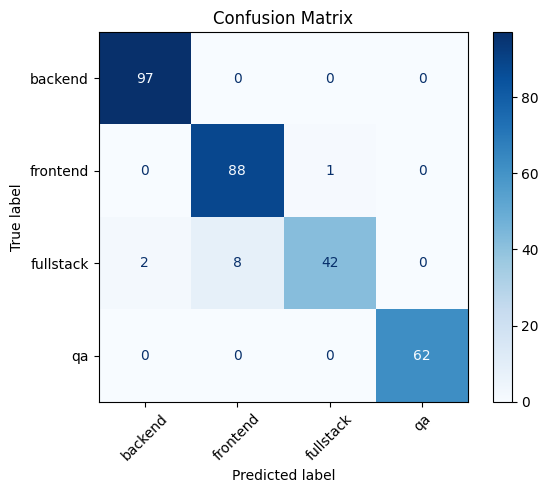

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

Plotting calibration for class: backend


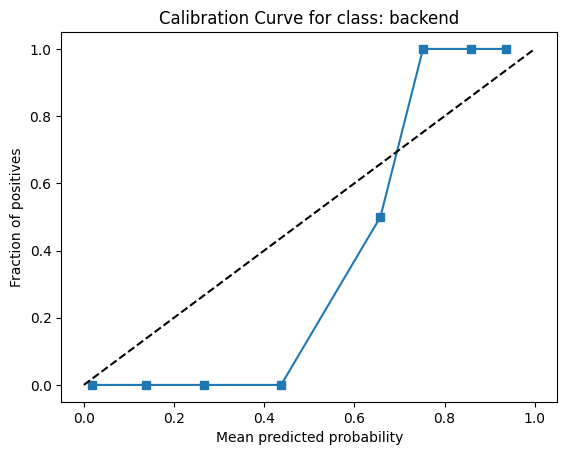

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Note: calibration_curve is primarily for binary classification.
# For multi-class, you might need to adapt or use other techniques.

# Use log_reg instead of model
# The .predict_proba gives probabilities for each class.
# You would typically analyze calibration for each class separately in multi-class.
# For demonstration, let's plot for one class (e.g., the first class in log_reg.classes_)
class_index_to_plot = 0 # You can change this to the index of the class you want to analyze

if len(log_reg.classes_) == 2:
    # Binary case: directly use predict_proba for the positive class
    prob_pos = log_reg.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Calibration Curve")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.show()
else:
    # Multi-class case: plot calibration for a specific class
    print(f"Plotting calibration for class: {log_reg.classes_[class_index_to_plot]}")
    # Create a binary target for the selected class
    y_test_binary = (y_test == log_reg.classes_[class_index_to_plot])
    prob_pos = log_reg.predict_proba(X_test)[:, class_index_to_plot]

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test_binary, prob_pos, n_bins=10)

    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"Calibration Curve for class: {log_reg.classes_[class_index_to_plot]}")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.show()

In [16]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Create the DataFrame containing true and predicted values along with commit types
# Ensure y_test.index is used to align with DATA
df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred, "committype": DATA.loc[y_test.index, 'committype']})

results_list = []

for ct in df["committype"].unique():
    subset = df[df["committype"] == ct]
    y_true_subset = subset["y_true"]
    y_pred_subset = subset["y_pred"]

    # Get unique labels in the subset to use for metrics calculation
    subset_labels = sorted(y_true_subset.unique())

    # Calculate metrics for the subset
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true_subset, y_pred_subset, labels=subset_labels, average=None, zero_division=0
    )

    # Store results
    for i, label in enumerate(subset_labels):
        results_list.append({
            "Commit Type": ct,
            "Role": label,
            "Precision": precision[i],
            "Recall": recall[i],
            "F1-Score": f1[i],
            "Support": support[i]
        })

# Create a DataFrame from the results
metrics_df = pd.DataFrame(results_list)

# Display the DataFrame
display(metrics_df)

,Commit Type,Role,Precision,Recall,F1-Score,Support
0,test,fullstack,0.000000,0.000000,0.000000,2
1,test,qa,1.000000,1.000000,1.000000,47
2,feature,backend,1.000000,1.000000,1.000000,52
3,feature,frontend,0.983871,1.000000,0.991870,61
4,feature,fullstack,1.000000,0.941176,0.969697,17
5,bugfix,backend,1.000000,1.000000,1.000000,34
6,bugfix,frontend,0.615385,1.000000,0.761905,8
7,bugfix,fullstack,1.000000,0.772727,0.871795,22
8,bugfix,qa,1.000000,1.000000,1.000000,15
9,refactor,backend,0.916667,1.000000,0.956522,11


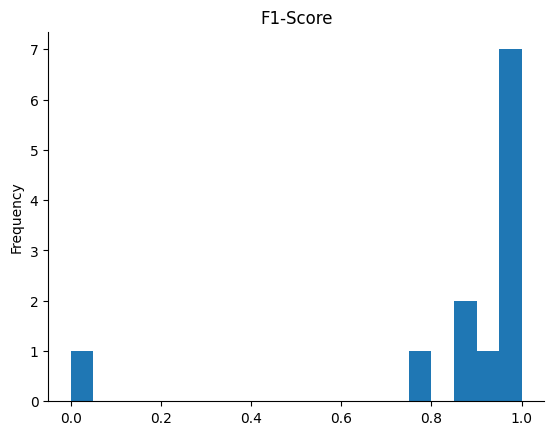

In [19]:
from matplotlib import pyplot as plt
metrics_df['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=metrics_df)

https://docs.google.com/spreadsheets/d/1C0jsZvI13_51Bso7w_As6Be3HvGYyKrdvl_MxwRi7Ac/edit#gid=0
